# Explaining AutoGluon-Tabular Predictions with Kernel SHAP for Binary Classification

This example uses a processed version of the <a href="https://archive.ics.uci.edu/ml/datasets/Adult">adult census income dataset</a> from the UCI machine learning data repository, which is a binary classification task. We train an AutoGluon classifier and then explain each of its predictions via [Shapely values](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) that quantify how much each feature contributed to a particular AutoGluon-prediction deviating from some "baseline" value. We use the [Kernel SHAP variant](https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html) which is appropriate for explaining arbitrary black-box models like the potentially heterogeneous ensemble of many models that AutoGluon-Tabular uses to make its predictions.

You must first install the [SHAP package](https://github.com/slundberg/shap/) (`pip install shap`).

**References:**  This notebook is derived from a [similar notebook](https://shap.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Census%20income%20classification%20with%20scikit-learn.html) that demonstrates how to use Kernel SHAP with sklearn classification models. For more Kernel SHAP examples, you may refer to [this article](https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a). Note that this notebook only demonstrates data that have already been preprocessed to only contain numerical features; handling of data with categorical features is demonstrated in the notebook: "SHAP with AutoGluon-Tabular and Categorical Features".


In [1]:
from autogluon.tabular import TabularPrediction as task
import pandas as pd
import sklearn
import shap

shap.initjs()

import warnings
warnings.filterwarnings('ignore')

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.


## Load the census data

In [2]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=7)

## Train AutoGluon classifier

Here we just train directly on the raw data, without any normalizations. We first format the data in a manner suitable for AutoGluon training (pandas DataFrame):

In [3]:
label_name = 'label'
feature_names = X_train.columns
train_data = X_train.copy()
train_data[label_name] = y_train
val_data = X_valid.copy()

display(train_data.head())

Age  Workclass  Education-Num  Marital Status  Occupation  \
12011  51.0          4           10.0               0           6   
23599  51.0          1           14.0               6          12   
23603  21.0          4           11.0               4           3   
6163   25.0          4           10.0               4          12   
14883  48.0          4           13.0               0           1   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
12011             0     4    0           0.0           0.0            40.0   
23599             1     4    1           0.0           0.0            50.0   
23603             3     2    1           0.0           0.0            40.0   
6163              3     4    1           0.0           0.0            24.0   
14883             3     4    1           0.0           0.0            38.0   

       Country  label  
12011       21  False  
23599        8   True  
23603       39  False  
6163        39  False  
14883       39   True

We then train an AutoGluon classifier:

In [4]:
predictor = task.fit(train_data, label=label_name, problem_type='binary', time_limits=20)

No output_directory specified. Models will be saved in: AutogluonModels/ag-20201021_064632/
Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to AutogluonModels/ag-20201021_064632/
AutoGluon Version:  0.0.15b20201020
Train Data Rows:    26048
Train Data Columns: 12
Preprocessing data ...
NumExpr defaulting to 4 threads.
Selected class <--> label mapping:  class 1 = True, class 0 = False
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5280.0 MB
	Train Data (Original)  Memory Usage: 1.09 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator.

## Explain predictions

SHAP is intended to explain how much each feature contributes to a particular prediction. In this binary classification context, "how much" is quantified in terms of the deviation between predicted probability of the positive class from a baseline reference value. Let's first print which `y` value AutoGluon considers to be the "positive" class:

In [5]:
print("positive class:", [label for label in predictor.class_labels if predictor.class_labels_internal_map[label]==1][0])

positive class: True


Next we create a wrapper class around AutoGluon to allow it to be called for prediction inside of the `shap` package:

In [6]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict_proba(X)

Next, we define the baseline reference value of the features, which we simply take to be the median value of each column here. AutoGluon predictions will be interpreted in terms of their difference from the prediction for the baseline feature-values.

**Note:** We use the median here following the [original notebook from the SHAP package](https://shap.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Census%20income%20classification%20with%20scikit-learn.html). However, this is actually an inappropriate baseline value for ordinally-encoded categorical features, where the median is meaningless (using the mode instead would be better for such categorical features). See also the notebook: "SHAP with AutoGluon-Tabular and Categorical Features".

In [7]:
med = X_train.median()  # X_train.mode() would be a more appropriate baseline for ordinally-encoded categorical features
print("Baseline feature-values: \n", med)

Baseline feature-values: 
 Age               37.0
Workclass          4.0
Education-Num     10.0
Marital Status     2.0
Occupation         7.0
Relationship       3.0
Race               4.0
Sex                1.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           39.0
dtype: float64


We can now create a `KernelExplainer` which will return Kernel SHAP values to explain particular AutoGluon predictions.

In [8]:
ag_wrapper = AutogluonWrapper(predictor, feature_names)
explainer = shap.KernelExplainer(ag_wrapper.predict_binary_prob, med)

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower
N_VAL = 30  # how many datapoints from validation data should we interpret predictions for, larger values will be slower

Let's first explain a prediction for a single datapoint from the training data.

In [9]:
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict_binary_prob(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values_single, X_display.iloc[ROW_INDEX,:])

num_full_subsets = 3
phi = [ 0.01592316 -0.03986782 -0.00479951 -0.0133586  -0.00654064  0.01095688]


We can also plot Kernel SHAP explanations aggregated across many predictions, say over the first `N_VAL` datapoints of the validation data. 

In [10]:
shap_values = explainer.shap_values(X_valid.iloc[0:N_VAL,:], nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values, X_valid.iloc[0:N_VAL,:])

num_full_subsets = 3
phi = [ 0.00830333 -0.05058271  0.04100702 -0.00816081 -0.01659751 -0.00682792]
num_full_subsets = 2
remaining_weight_vector = [1.]
num_paired_subset_sizes = 3
weight_left = 0.23809523809523808
phi = [ 0.07460753  0.04250878  0.14088953 -0.04436716  0.17576086  0.0380924
  0.1665812 ]
num_full_subsets = 2
phi = [-0.13599977  0.01178839  0.09874567 -0.02236498]
num_full_subsets = 3
phi = [-0.03529571  0.00191008 -0.00053151 -0.02854812  0.02955724  0.0056655 ]
num_full_subsets = 3
phi = [-0.00373857 -0.03997323  0.13348722  0.10074678  0.19616302 -0.15294519]
num_full_subsets = 1
remaining_weight_vector = [0.39215686 0.31372549 0.29411765]
num_paired_subset_sizes = 3
weight_left = 0.559228650137741
phi = [ 0.01386484 -0.0050063   0.07838247 -0.04207132  0.07804059 -0.0116172
 -0.07561353  0.05126844]
num_full_subsets = 2
phi = [-0.06480843 -0.01473881  0.00022362  0.02634984]
num_full_subsets = 2
phi = [ 0.01423149 -0.05476653 -0.04418569  0.04859776  0.21089789]
nu

A summary plot is an even better way to see the relative impact of all features over many datapoints. Features are sorted by the sum of their SHAP value magnitudes across all samples.

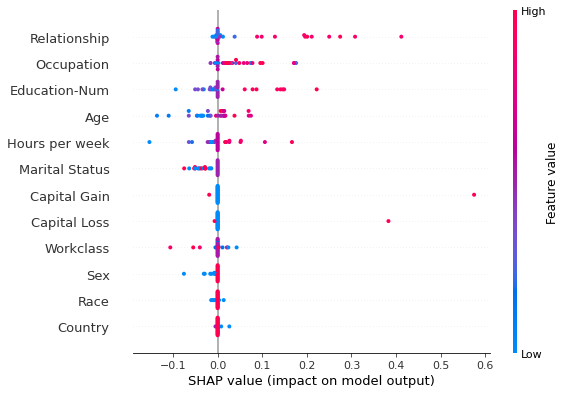

In [11]:
shap.summary_plot(shap_values, X_valid.iloc[0:N_VAL,:])

A dependence plot can be used to visualize how the number of years of education increases the chance of making over 50K annually.

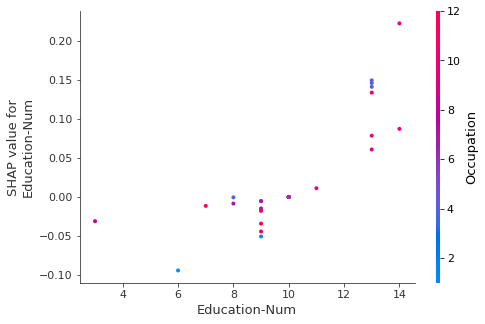

In [12]:
shap.dependence_plot("Education-Num", shap_values, X_valid.iloc[0:N_VAL,:])

## Scoring Overall Feature Importance via Permutation Shuffling

Note that if you'd like to understand how much each feature contributes to AutoGluon's general predictive accuracy (rather than explaining individual predictions), AutoGluon offers a built-in method for this based on [permutation-shuffling](https://explained.ai/rf-importance/):

In [13]:
val_data[label_name] = y_valid  # add labels to validation DataFrame
predictor.feature_importance(val_data)

Computing raw permutation importance for 12 features on weighted_ensemble_k0_l1 ...
	14.81s	= Expected runtime
	12.33s	= Actual runtime


Capital Gain      0.054
Education-Num     0.031
Relationship      0.028
Capital Loss      0.013
Occupation        0.012
Age               0.011
Workclass         0.009
Marital Status    0.006
Country          -0.001
Race             -0.001
Hours per week   -0.002
Sex              -0.008
dtype: float64

Features with near zero or negative importance score above hardly contribute at all to AutoGluon's overall accuracy on the validation data, whereas features near the top of this list contain the most predictive signal.